# **Evaluation and optimization of red pine needle-reinforced roller-compacted concrete by bioinspired algorithms**
### **Authors:** Sadik Alper Yildizel, Mehmet Uzun, Kemal Armagan, Togay Ozbakkaloglu

📄 **Paper Link:** [Click here](https://www.sciencedirect.com/science/article/abs/pii/S245221392400264X?via%3Dihub)  

## **Project Overview**
### This project aims to replicate the methodology and results of the referenced paper, which focuses on optimizing RCC mix designs using machine learning and optimization algorithms.

## **Machine Learning Model Used**
- Artificial Neural Network (ANN)
- Multilinear Regression Model

## **Optimization Algorithms Implemented**
- Genetic Algorithm (GA)
- Particle Swarm Optimization (PSO)
- Simulated Annealing (SA)

 **📝 NOTE:** Since the original dataset was not provided in the paper, synthetic data was generated for this study. As a result, the reproduced results may not perfectly match real experimental outcomes.

## Import necessary libraries

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib 
from sklearn.linear_model import LinearRegression
from scipy.optimize import differential_evolution
import community as community_louvain
from sklearn.metrics.pairwise import euclidean_distances
from deap import base, creator, tools, algorithms
import networkx as nx
from pyswarm import pso
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_all(seed=42):
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fix hash-based randomization

# Usage
seed_all(42)

## Available data extracted from the paper

In [3]:
# Sample mix design data (Extracted from paper tables & graphs)
data = {
    'W/C': [0.4, 0.407, 0.419, 0.438, 0.45],
    'PN_Fiber (%)': [0.0, 0.5, 1.0, 1.5, 2.0],
    'Superplasticizer (kg/m³)': [1.3, 2.6, 3.25, 3.9, 4.55],
    'CS_28d': [32.89, 31.77, 29.81, 27.93, 26.41],  # Approximate values from graph
    'FS_28d': [8.75, 8.87, 8.98, 9.16, 8.66]  # Approximate values from graph
}

# Convert data to DataFrame
df = pd.DataFrame(data)
df

,W/C,PN_Fiber (%),Superplasticizer (kg/m³),CS_28d,FS_28d
0,0.400,0.0,1.30,32.89,8.75
1,0.407,0.5,2.60,31.77,8.87
2,0.419,1.0,3.25,29.81,8.98
3,0.438,1.5,3.90,27.93,9.16
4,0.450,2.0,4.55,26.41,8.66


## Multilinear regression model

In [4]:
seed_all(42)

# Define input (features) and output (targets)
X = df[['W/C', 'PN_Fiber (%)', 'Superplasticizer (kg/m³)']]
y_cs = df[['CS_28d']]
y_fs = df[['FS_28d']]

# Train multilinear regression models
model_cs = LinearRegression()
model_fs = LinearRegression()
model_cs.fit(X, y_cs)
model_fs.fit(X, y_fs)

# Print regression coefficients
print("Compressive Strength Model Coefficients:", model_cs.coef_)
print("Compressive Strength Intercept:", model_cs.intercept_)
print("Flexural Strength Model Coefficients:", model_fs.coef_)
print("Flexural Strength Intercept:", model_fs.intercept_)

Compressive Strength Model Coefficients: [[-20.          -3.82         0.63076923]]
Compressive Strength Intercept: [40.07]
Flexural Strength Model Coefficients: [[53.57142857 -3.14642857  1.13131868]]
Flexural Strength Intercept: [-14.14928571]


In [5]:
# Function to Predict CS and FS using the regression model
def predict_strength_regression(w_c, pn, sp):
    input_data = np.array([[w_c, pn, sp]])
    cs_pred = model_cs.predict(input_data)[0][0]
    fs_pred = model_fs.predict(input_data)[0][0]
    return cs_pred, fs_pred

# Test prediction
w_c_test, pn_test, sp_test = 0.45, 2.0, 4.55
cs_pred, fs_pred = predict_strength_regression(w_c_test, pn_test, sp_test)
print(f"Predicted CS: {cs_pred:.2f} MPa, Predicted FS: {fs_pred:.2f} MPa")

Predicted CS: 26.30 MPa, Predicted FS: 8.81 MPa


## Synthetic samples

In [6]:
# Compute mean of each feature
mean_values = df.mean()

# Print the mean
print("Mean of each feature:")
print(mean_values)

Mean of each feature:
W/C                          0.4228
PN_Fiber (%)                 1.0000
Superplasticizer (kg/m³)     3.1200
CS_28d                      29.7620
FS_28d                       8.8840
dtype: float64


In [7]:
# Compute standard deviation of each feature
std_values = df.std()

# Print the standard deviation
print("Standard deviation of each feature:")
print(std_values)

Standard deviation of each feature:
W/C                         0.020945
PN_Fiber (%)                0.790569
Superplasticizer (kg/m³)    1.250300
CS_28d                      2.665093
FS_28d                      0.196036
dtype: float64


In [8]:
seed_all(42)

# Define Gaussian distribution parameters (Mean, Standard Deviation)
params = {
    "W/C": (0.42, 0.02),  # Mean = 0.46, Std Dev = 0.02
    "PN_Fiber (%)": (1.0, 0.5),  # Mean = 1.0%, Std Dev = 0.5%
    "SP (kg/m³)": (3.12, 1.25),  # Mean = 2.5 kg/m³, Std Dev = 0.7
}

# Generate 100 synthetic samples
num_samples = 100
data = {key: np.random.normal(loc=mean, scale=std, size=num_samples) for key, (mean, std) in params.items()}

# Convert to DataFrame
df_synthetic = pd.DataFrame(data)

# Ensure realistic values by applying constraints
df_synthetic["W/C"] = df_synthetic["W/C"].clip(0.40, 0.50)
df_synthetic["PN_Fiber (%)"] = df_synthetic["PN_Fiber (%)"].clip(0.0, 2.0)
df_synthetic["SP (kg/m³)"] = df_synthetic["SP (kg/m³)"].clip(1.3, 4.55)

df_synthetic.describe()


,W/C,PN_Fiber (%),SP (kg/m³)
count,100.000000,100.000000,100.000000
mean,0.419687,1.004283,3.134171
std,0.015252,0.460063,1.050479
min,0.400000,0.040614,1.300000
25%,0.407982,0.597170,2.300696
50%,0.417461,1.042054,3.242120
75%,0.428119,1.269085,4.000547
max,0.457046,2.000000,4.550000


In [9]:
cs_values = []
fs_values = []

for index, row in df_synthetic.iterrows():
    w_c = row['W/C']
    pn = row['PN_Fiber (%)']
    sp = row['SP (kg/m³)']
    
    cs, fs = predict_strength_regression(w_c, pn, sp)
    
    cs_values.append(cs)
    fs_values.append(fs)

df_synthetic["CS_28d"] = cs_values
df_synthetic["FS_28d"] = fs_values

df_synthetic.head()

,W/C,PN_Fiber (%),SP (kg/m³),CS_28d,FS_28d
0,0.429934,0.292315,3.567234,32.604774,11.998840
1,0.417235,0.789677,3.820981,31.118895,10.040657
2,0.432954,0.828643,4.473814,31.067454,11.498711
3,0.450461,0.598861,4.437253,31.572020,13.118204
4,0.415317,0.919357,1.397913,29.133478,6.788630


In [10]:
df_synthetic.describe()

,W/C,PN_Fiber (%),SP (kg/m³),CS_28d,FS_28d
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.419687,1.004283,3.134171,29.816835,8.719797
std,0.015252,0.460063,1.050479,1.879203,2.168131
min,0.400000,0.040614,1.300000,24.666101,3.780852
25%,0.407982,0.597170,2.300696,28.454539,6.917624
50%,0.417461,1.042054,3.242120,29.917631,8.925992
75%,0.428119,1.269085,4.000547,31.409612,10.192846
max,0.457046,2.000000,4.550000,34.118345,13.619987


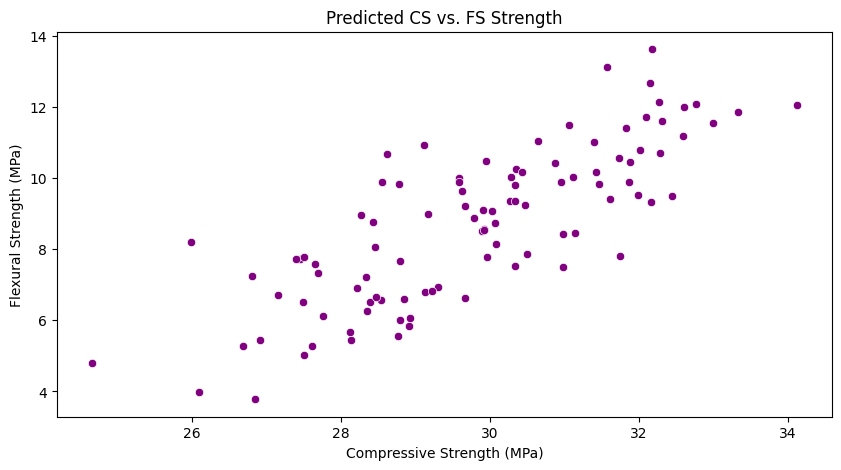

In [11]:
# Scatter plot of predicted strengths
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_synthetic["CS_28d"], y=df_synthetic["FS_28d"], color='purple')
plt.xlabel("Compressive Strength (MPa)")
plt.ylabel("Flexural Strength (MPa)")
plt.title("Predicted CS vs. FS Strength")
plt.show()


## ANN model

In [63]:
X = df_synthetic[['W/C', 'PN_Fiber (%)', 'SP (kg/m³)']].values
y = df_synthetic[['CS_28d', 'FS_28d']].values

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Train size: {len(X_train)}')
print(f'Test size: {len(X_test)}')

Train size: 70
Test size: 30


In [65]:
seed_all(42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [66]:
seed_all(42)

# Define the ANN model (Multitask Learning for CS and FS)
ann_model = Sequential(
    [
        Dense(3, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(9, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(9, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(9, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(9, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(2, activation='linear')
    ],
)

In [67]:
seed_all(42)

def train_and_test_model(model, X_train, y_train, X_test, y_test, model_name, epoch=100):

    # Compile the model with MSE as both loss and metric
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['mse']  # Track MSE for both train and validation
    )

    print(f"Training {model_name}...")

    # Define callbacks for early stopping and saving the best model
    checkpoint_path = f"{model_name}_best.keras"
    model_checkpoint = ModelCheckpoint(
        checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model (Validation data is test data in this case)
    history = model.fit(
        X_train, y_train,
        epochs=epoch,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    print(f"Best model saved at: {checkpoint_path}")

    # Load the best model before evaluation
    best_model = tf.keras.models.load_model(checkpoint_path)

    # Evaluate on Training and Test Data
    yhat_train = best_model.predict(X_train)
    yhat_test = best_model.predict(X_test)

    # Separate the predictions for CS and FS
    y_train_cs, y_train_fs = y_train[:, 0], y_train[:, 1]
    y_test_cs, y_test_fs = y_test[:, 0], y_test[:, 1]
    yhat_train_cs, yhat_train_fs = yhat_train[:, 0], yhat_train[:, 1]
    yhat_test_cs, yhat_test_fs = yhat_test[:, 0], yhat_test[:, 1]

    # Compute metrics separately for CS and FS
    metrics = {}
    for name, (y_t, y_p) in zip(["CS", "FS"], 
                             [(y_test_cs, yhat_test_cs), (y_test_fs, yhat_test_fs)]):
        metrics[name] = {
            "RMSE": np.sqrt(mean_squared_error(y_t, y_p)),
            "R² Score": r2_score(y_t, y_p),
            "MAE": mean_absolute_error(y_t, y_p),
            "MAPE": mean_absolute_percentage_error(y_t, y_p) * 100  # Convert to percentage
        }

    # Print Evaluation Metrics
    print("\nModel Evaluation on Test Data:")
    for key, values in metrics.items():
        print(f"\nMetrics for {key}:")
        print(f"RMSE: {values['RMSE']:.4f}")
        print(f"R² Score: {values['R² Score']:.4f}")
        print(f"MAE: {values['MAE']:.4f}")
        print(f"MAPE: {values['MAPE']:.2f}%")

    # Plot Training History
    plot_training_history(history, model_name)

def plot_training_history(history, model_name):

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')  
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"{model_name}_training_plot.png")
    plt.show()


Training ANN_model...
Epoch 1/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - loss: 475.8845 - mse: 475.5402
Epoch 1: val_loss improved from inf to 493.13657, saving model to ANN_model_best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 474.5725 - mse: 474.2296 - val_loss: 493.1366 - val_mse: 492.8014
Epoch 2/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 467.0610 - mse: 466.7258
Epoch 2: val_loss improved from 493.13657 to 480.28134, saving model to ANN_model_best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 465.2567 - mse: 464.9222 - val_loss: 480.2813 - val_mse: 479.9497
Epoch 3/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 453.9399 - mse: 453.6083
Epoch 3: val_loss improved from 480.28134 to 460.32404, saving model to ANN_model_best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 451.2407 - mse: 450.9091 - val_loss: 460.3240 - val_mse: 459.9912
Epoch 4/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 433.7778 - mse: 433.4449
Epoch 4: val_loss improved from 460.32

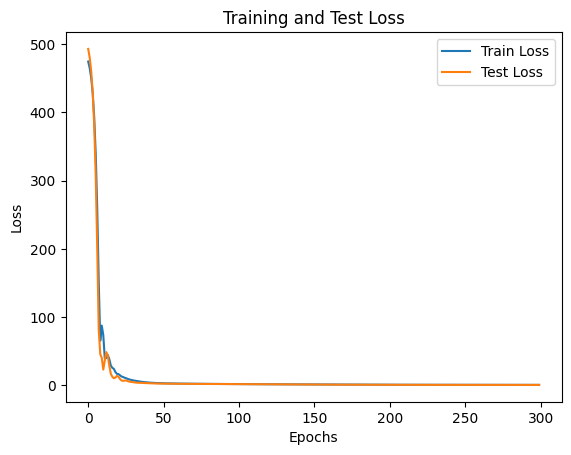

In [68]:
# Train and test the model
train_and_test_model(ann_model, X_train_scaled, y_train, X_test_scaled, y_test, model_name="ANN_model", epoch=300)

### Perfromance metrics of ANN

In [202]:
# Data for CS metrics
cs_metrics = {
    "Metric": ["RMSE", "R² Score", "MAE", "MAPE"],
    "Value": [0.2281, 0.9854, 0.1830, 0.61]
}

# Data for FS metrics
fs_metrics = {
    "Metric": ["RMSE", "R² Score", "MAE", "MAPE"],
    "Value": [0.2564, 0.9866, 0.2051, 2.59]
}

# Creating DataFrames
df_cs = pd.DataFrame(cs_metrics)
df_fs = pd.DataFrame(fs_metrics)

In [203]:
df_cs

,Metric,Value
0,RMSE,0.2281
1,R² Score,0.9854
2,MAE,0.1830
3,MAPE,0.6100


In [204]:
df_fs

,Metric,Value
0,RMSE,0.2564
1,R² Score,0.9866
2,MAE,0.2051
3,MAPE,2.5900


# Optimization algorithms

## Genetic Algorithm (GA)
- 30 random samples are considered from the synthetic dataset
- Fitness function: CS + FS = Maximize
- Used: Louvain Clustering from the ref. paper 

In [335]:
random_samples = df_synthetic.sample(n=30, random_state=42) 
random_samples.head()

,W/C,PN_Fiber (%),SP (kg/m³),CS_28d,FS_28d
83,0.409635,1.241236,1.572731,28.127816,5.669223
53,0.432234,1.116127,4.410582,29.943784,10.484042
70,0.427228,0.555243,4.550000,32.274414,12.138392
45,0.405603,1.390911,2.701873,28.348915,6.259729
44,0.400000,1.129941,1.619629,28.775236,5.556323


In [336]:

mix_designs = random_samples[['W/C', 'PN_Fiber (%)', 'SP (kg/m³)', 'CS_28d', 'FS_28d']].values
mix_designs

array([[ 0.4096346 ,  1.24123621,  1.57273063, 28.12781586,  5.66922324],
       [ 0.43223353,  1.11612685,  4.41058158, 29.94378407, 10.48404166],
       [ 0.42722791,  0.55524279,  4.55      , 32.27441432, 12.1383921 ],
       [ 0.40560312,  1.39091144,  2.70187346, 28.34891464,  6.25972907],
       [ 0.4       ,  1.1299414 ,  1.61962949, 28.77523631,  5.55632292],
       [ 0.42393722,  0.38456784,  4.18554167, 32.76231725, 12.08680327],
       [ 0.42135056,  1.70139716,  3.97782524, 27.65274135,  7.56992932],
       [ 0.41560656,  1.31283367,  3.26189668, 28.80034818,  7.67485882],
       [ 0.41073165,  0.04061439,  3.83361314, 34.11834531, 12.06344321],
       [ 0.42993428,  0.29231463,  3.5672342 , 32.60477403, 11.99883961],
       [ 0.40183952,  1.57141141,  2.51329557, 27.61572756,  5.27683582],
       [ 0.40796587,  0.22466828,  2.20704171, 32.4445838 ,  9.49599344],
       [ 0.45129287,  1.17057599,  3.13279133, 28.54861064,  9.88816982],
       [ 0.4       ,  1.23679622,  2.3

In [337]:
# Convert Mix Designs into a Similarity Graph
X = mix_designs[:, :3]  # Extract W/C, Superplasticizer, Pine Needles %
distances = euclidean_distances(X)
similarity_matrix = 1 / (1 + distances)  # Convert distance to similarity (0-1 scale)

G = nx.Graph()
for i in range(len(mix_designs)):
    G.add_node(i, mix_design=mix_designs[i])

threshold = 0.8  # Connect nodes if similarity > threshold
for i in range(len(mix_designs)):
    for j in range(i + 1, len(mix_designs)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

print(f"Graph Created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph Created with 30 nodes and 16 edges.


In [338]:
#Apply Louvain Clustering
partition = community_louvain.best_partition(G, weight='weight')
clusters = {}
for node, cluster_id in partition.items():
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(mix_designs[node])

# Convert clusters to numpy arrays
for key in clusters:
    clusters[key] = np.array(clusters[key])

print(f"Louvain Clustering Done! Found {len(clusters)} clusters.")

Louvain Clustering Done! Found 17 clusters.


### Load pre-trained ANN model

In [ ]:
# Load the model
ann_model = tf.keras.models.load_model(r'E:\Mission Higher Study in US\Professors\Universities\Texas State University\Dr Togay Ozbakkaloglu\ANN_model_best.keras')

# Summary of the model
ann_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 9)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 9)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 9)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 9)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016 (3.97 KB)

 Trainable params: 338 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 678 (2.65 KB)

In [340]:
# Define a function to enforce bounds 
def checkBounds(individual, lower_bounds, upper_bounds):
    for i, val in enumerate(individual):
        if val < lower_bounds[i]:
            individual[i] = lower_bounds[i]
        elif val > upper_bounds[i]:
            individual[i] = upper_bounds[i]
    return individual

lower_bounds = [0.3, 0, 1]   # minimum values for W/C, %Pine Needle, Superplasticizer
upper_bounds = [0.5, 2, 5]   # maximum values for these parameters

In [341]:
seed_all(42)

# Define Genetic Algorithm (GA) for Optimization 
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, 
                 lambda: list(mix_designs[random.randint(0, len(mix_designs)-1)][:3]))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def fitness_function(individual):
    
    w_c, pn, sp = individual
    input_data = np.array([[w_c, pn, sp]])
    scaled_input = scaler.transform(input_data)
    cs, fs = ann_model.predict(scaled_input)[0]
    return (cs + fs,)

# Register GA operators
toolbox.register("evaluate", fitness_function)

# Define custom crossover and mutation operators that enforce bounds
def mateAndBound(ind1, ind2, alpha):
    tools.cxBlend(ind1, ind2, alpha)
    checkBounds(ind1, lower_bounds, upper_bounds)
    checkBounds(ind2, lower_bounds, upper_bounds)
    return ind1, ind2

def mutateAndBound(individual, mu, sigma, indpb):
    tools.mutGaussian(individual, mu, sigma, indpb)
    checkBounds(individual, lower_bounds, upper_bounds)
    return (individual,)

toolbox.register("mate", mateAndBound, alpha=0.3)
toolbox.register("mutate", mutateAndBound, mu=0, sigma=0.01, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [342]:
seed_all(42)

# Apply GA to each cluster
optimized_mixes = []
for key in clusters:
    print(f"Running GA on Cluster {key}...")
    
    population = toolbox.population(n=len(clusters[key]))  # Use cluster size as population
    final_population = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=50, verbose=False)

    # Extract best solutions per cluster
    best_mixes = sorted(final_population[0], key=lambda x: fitness_function(x), reverse=True)[:1]
    optimized_mixes.extend(best_mixes)

Running GA on Cluster 4...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [344]:
optimized_mixes

[[0.45237132247533, 0.6377221629714973, 2.529906683605851],
 [0.44766189018123714, 0.3025528168411986, 4.136191338553057],
 [0.4224416552311732, 1.312833673882503, 3.26189668156406],
 [0.43928751151837603, 1.0893161832607485, 2.1252439206129954],
 [0.45836111829070214, 0.714181806156601, 2.9845943230644707],
 [0.459322416506687, 1.170575987408322, 3.1304236144298723],
 [0.4278039208104163, 0.9584134631002791, 3.224469753998194],
 [0.44460443297740504, 0.4807842928597374, 4.3896781485542995],
 [0.4584217993650468, 1.1104132828414048, 4.420529390980366],
 [0.4159082003852089, 0.5047318374346559, 3.203846950218878],
 [0.47269162997330616, 0.960601883253487, 4.576413117126479],
 [0.4064537352561088, 0.555483813510489, 4.203546348009659],
 [0.4272540844281117, 0.2923146289747929, 3.567234200435354],
 [0.41354829394200254, 0.6095851266938297, 3.283876309248018],
 [0.41134155758026136, 1.2415220054021454, 2.33521984000792],
 [0.42837243100373557, 0.5564402705951224, 3.286112476946739],
 [0.43

In [345]:
top_10_mixes = sorted(optimized_mixes, key=lambda x: fitness_function(x), reverse=True)[:10]
top_10_mixes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[[0.44766189018123714, 0.3025528168411986, 4.136191338553057],
 [0.47269162997330616, 0.960601883253487, 4.576413117126479],
 [0.44460443297740504, 0.4807842928597374, 4.3896781485542995],
 [0.4272540844281117, 0.2923146289747929, 3.567234200435354],
 [0.4064537352561088, 0.555483813510489, 4.203546348009659],
 [0.42837243100373557, 0.5564402705951224, 3.286112476946739],
 [0.4159082003852089, 0.5047318374346559, 3.203846950218878],
 [0.4399231331578097, 0.9854154525147323, 4.54366602121032],
 [0.4584217993650468, 1.1104132828414048, 4.420529390980366],
 [0.45836111829070214, 0.714181806156601, 2.9845943230644707]]

In [346]:
# Create a DataFrame with columns 'w/c', 'pn', and 'sp'
df_ga = pd.DataFrame(top_10_mixes, columns=["w/c", "pn", "sp"])

df_ga_ann = df_ga.copy()

### GA optimizer prediction results using ANN model

In [347]:
# Prepare the input data from the DataFrame (as a 2D array)
input_data = df_ga_ann[["w/c", "pn", "sp"]].values

# Prediction
scaled_data = scaler.transform(input_data)
predictions = ann_model.predict(scaled_data)

# Add the predictions to the DataFrame as new columns
df_ga_ann["cs_28d_pred"] = predictions[:, 0]
df_ga_ann["fs_28d_pred"] = predictions[:, 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [348]:
df_ga_ann

,w/c,pn,sp,cs_28d_pred,fs_28d_pred
0,0.447662,0.302553,4.136191,33.339203,13.545550
1,0.472692,0.960602,4.576413,31.899569,13.769893
2,0.444604,0.480784,4.389678,32.228069,13.129887
3,0.427254,0.292315,3.567234,32.721458,11.754042
4,0.406454,0.555484,4.203546,32.543892,10.400255
5,0.428372,0.556440,3.286112,31.586775,10.555614
6,0.415908,0.504732,3.203847,32.112991,9.860409
7,0.439923,0.985415,4.543666,30.122402,11.640408
8,0.458422,1.110413,4.420529,29.429842,12.214273
9,0.458361,0.714182,2.984594,30.047007,11.578199


### Treating multilinear regression prediction as the original/real mechanical testing data

In [349]:
cs_values = []
fs_values = []

for index, row in df_ga.iterrows():
    w_c = row['w/c']
    pn = row['pn']
    sp = row['sp']
    
    cs, fs = predict_strength_regression(w_c, pn, sp)
    
    cs_values.append(cs)
    fs_values.append(fs)

df_ga["cs_28d"] = cs_values
df_ga["fs_28d"] = fs_values

df_ga

,w/c,pn,sp,cs_28d,fs_28d
0,0.447662,0.302553,4.136191,32.569993,13.559991
1,0.472692,0.960602,4.576413,29.833329,13.328397
2,0.444604,0.480784,4.389678,32.110189,13.122180
3,0.427254,0.292315,3.567234,32.658378,11.855258
4,0.406454,0.555484,4.203546,32.470445,10.632782
5,0.428372,0.556440,3.286112,31.449728,10.766078
6,0.415908,0.504732,3.203847,31.844648,10.167980
7,0.439923,0.985415,4.543666,30.373255,11.457820
8,0.458422,1.110413,4.420529,29.448119,11.916216
9,0.458361,0.714182,2.984594,30.057193,11.535179


### Performance metrics of GA

In [350]:
# Performance
y_ori_cs = df_ga['cs_28d'].values
y_ori_fs = df_ga['fs_28d'].values
yhat_cs  = df_ga_ann['cs_28d_pred'].values
yhat_fs  = df_ga_ann['fs_28d_pred'].values

# Compute metrics separately for CS and FS
metrics = {}
for name, (y_t, y_p) in zip(["CS", "FS"], [(y_ori_cs, yhat_cs), (y_ori_fs, yhat_fs)]):
    metrics[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_t, y_p)),
        "R² Score": r2_score(y_t, y_p),
        "MAE": mean_absolute_error(y_t, y_p),
        "MAPE": mean_absolute_percentage_error(y_t, y_p) * 100  # Convert to percentage
    }

# Print Evaluation Metrics
print('GA performance metrics:')
for key, values in metrics.items():
    print(f"\nMetrics for {key}:")
    print(f"RMSE: {values['RMSE']:.4f}")
    print(f"R² Score: {values['R² Score']:.4f}")
    print(f"MAE: {values['MAE']:.4f}")
    print(f"MAPE: {values['MAPE']:.2f}%")


GA performance metrics:

Metrics for CS:
RMSE: 0.7098
R² Score: 0.6345
MAE: 0.3775
MAPE: 1.23%

Metrics for FS:
RMSE: 0.2286
R² Score: 0.9581
MAE: 0.1839
MAPE: 1.60%


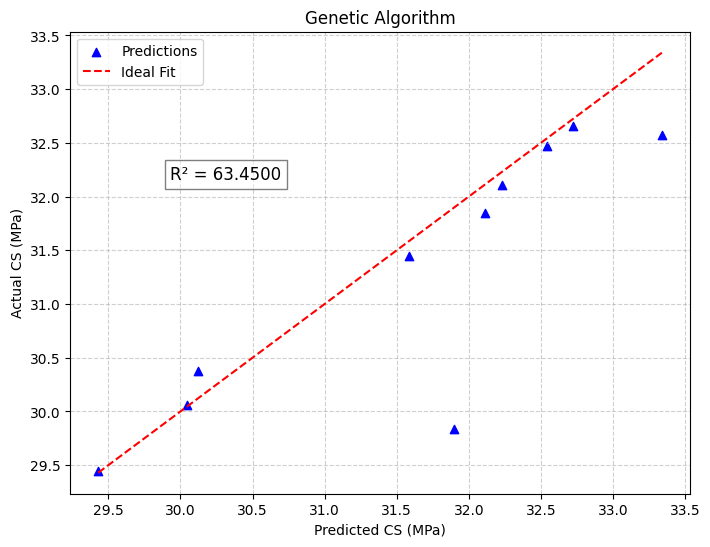

In [351]:
# Scatter plot for compressive strength
r2 = 63.45
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(yhat_cs, y_ori_cs, marker='^', color='blue', label="Predictions")  # Triangular points

# Plot ideal line
plt.plot([min(yhat_cs), max(yhat_cs)], [min(yhat_cs), max(yhat_cs)], color='red', linestyle='dashed', label="Ideal Fit")

# Labels and title
plt.xlabel("Predicted CS (MPa)")
plt.ylabel("Actual CS (MPa)")
plt.title("Genetic Algorithm")

# Display R² value on the plot
plt.text(min(yhat_cs) + 0.5, max(y_ori_cs) - 0.5, f"R² = {r2:.4f}", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("ga_cs_plot.png", dpi=300, bbox_inches="tight")
plt.show()




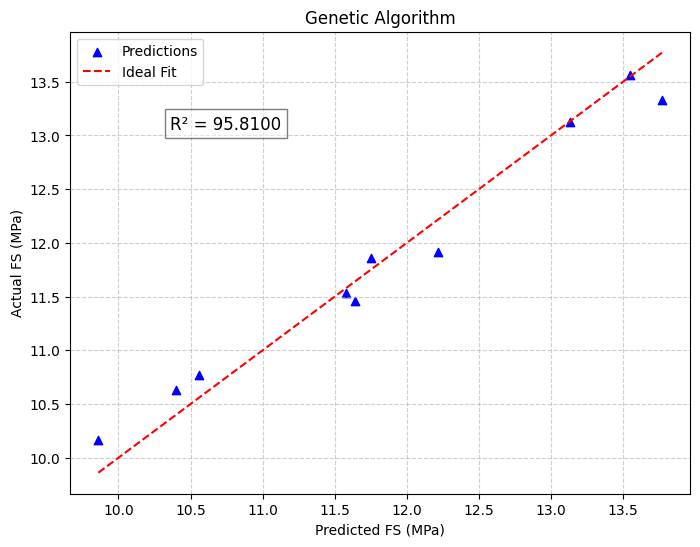

In [352]:
# Scatter plot for flexural strength
r2 = 95.81
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(yhat_fs, y_ori_fs, marker='^', color='blue', label="Predictions")  # Triangular points

# Plot ideal line
plt.plot([min(yhat_fs), max(yhat_fs)], [min(yhat_fs), max(yhat_fs)], color='red', linestyle='dashed', label="Ideal Fit")

# Labels and title
plt.xlabel("Predicted FS (MPa)")
plt.ylabel("Actual FS (MPa)")
plt.title("Genetic Algorithm")

# Display R² value on the plot
plt.text(min(yhat_fs) + 0.5, max(y_ori_fs) - 0.5, f"R² = {r2:.4f}", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("ga_fs_plot.png", dpi=300, bbox_inches="tight")
plt.show()




## Particle Swarm Optimization (PSO) Algorithm 
- According to the original paper particles, number of iterations, and weight are 30, 100, and 0.5 respectively  

In [205]:
seed_all(42)

# Extract W/C, PN Fiber, and SP values from the random_samples dataframe
particles = random_samples[['W/C', 'PN_Fiber (%)', 'SP (kg/m³)']].values

# PSO Parameters
num_particles = len(particles)  # Using the 30 pre-selected samples
max_iterations = 100
inertia_weight = 0.5
c1, c2 = 1.5, 1.5

# Initialize velocities randomly
velocities = np.random.uniform(-0.01, 0.01, (num_particles, 3))

In [208]:
seed_all(42)

# Define fitness function
def fitness_function(params):
    w_c, pn, sp = params
    input_data = np.array([[w_c, pn, sp]])
    scaled_input = scaler.transform(input_data)
    cs, fs = ann_model.predict(scaled_input)[0]
    return -(cs + fs)  # Maximizing strength

# Initialize personal bests and global best
personal_best = particles.copy()
personal_best_scores = [fitness_function(p) for p in personal_best]
global_best = min(personal_best, key=lambda x: fitness_function(x))
global_best_score = min(personal_best_scores)

no_improvement_count = 0
convergence_threshold = 10  # Stop if no improvement for 10 iterations

for iteration in range(max_iterations):
    for i in range(num_particles):
        fitness = fitness_function(particles[i])
        
        if fitness < personal_best_scores[i]:
            personal_best[i] = particles[i]
            personal_best_scores[i] = fitness
        if fitness < global_best_score:
            global_best = particles[i]
            global_best_score = fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        # Velocity Update Formula:
        # v_i = w * v_i + c1 * r1 * (P_best - x_i) + c2 * r2 * (G_best - x_i)
        velocities[i] = inertia_weight * velocities[i] + c1 * np.random.rand() * (personal_best[i] - particles[i]) + c2 * np.random.rand() * (global_best - particles[i])
        particles[i] = particles[i] + velocities[i]
        particles[i] = np.clip(particles[i], [0.30, 0.0, 1.0], [0.50, 2.0, 5.0])
    
    if no_improvement_count >= convergence_threshold:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [ ]:
# Select top 10 best mix designs
sorted_indices = np.argsort(personal_best_scores)[:10]
top_10_designs = personal_best[sorted_indices]

df_best_designs = pd.DataFrame(top_10_designs, columns=["w/c", "pn", "sp"])
#df_best_designs[["CS_28d", "FS_28d"]] = [predict_strength_regression(*mix) for mix in top_10_designs]

df_best_designs

,w/c,pn,sp
0,0.410732,0.040614,3.833613
1,0.417687,0.196258,3.751234
2,0.423937,0.384568,4.185542
3,0.429934,0.292315,3.567234
4,0.427228,0.555243,4.550000
5,0.425922,0.558071,4.244500
6,0.407966,0.224668,2.207042
7,0.409405,0.576603,3.471240
8,0.430851,0.962777,4.550000
9,0.400000,0.504732,3.200350


In [210]:
df_pso_ann = df_best_designs.copy()
df_pso = df_best_designs.copy()

### PSO algorithm prediction using ANN model

In [212]:
# Prepare the input data from the DataFrame (as a 2D array)
input_data = df_pso_ann[["w/c", "pn", "sp"]].values

# Prediction
scaled_data = scaler.transform(input_data)
predictions = ann_model.predict(scaled_data)

# Add the predictions to the DataFrame as new columns
df_pso_ann["cs_28d_pred"] = predictions[:, 0]
df_pso_ann["fs_28d_pred"] = predictions[:, 1]

df_pso_ann

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


,w/c,pn,sp,cs_28d_pred,fs_28d_pred
0,0.410732,0.040614,3.833613,34.406883,11.906889
1,0.417687,0.196258,3.751234,33.436703,11.689405
2,0.423937,0.384568,4.185542,32.768810,12.040689
3,0.429934,0.292315,3.567234,32.664791,11.917185
4,0.427228,0.555243,4.550000,32.164440,12.201753
5,0.425922,0.558071,4.244500,32.010708,11.726838
6,0.407966,0.224668,2.207042,32.039104,10.062605
7,0.409405,0.576603,3.471240,32.093781,9.667226
8,0.430851,0.962777,4.550000,30.461401,11.129095
9,0.400000,0.504732,3.200350,32.012604,9.575598


### Treating multilinear regression prediction as the original/real-time mechanical testing data

In [ ]:
cs_values = []
fs_values = []

for index, row in df_pso.iterrows():
    w_c = row['w/c']
    pn = row['pn']
    sp = row['sp']
    
    cs, fs = predict_strength_regression(w_c, pn, sp)
    
    cs_values.append(cs)
    fs_values.append(fs)

df_pso["cs_28d"] = cs_valuesQ
df_pso["fs_28d"] = fs_values

df_pso

,w/c,pn,sp,cs_28d,fs_28d
0,0.410732,0.040614,3.833613,34.118345,12.063443
1,0.417687,0.196258,3.751234,33.332715,11.853134
2,0.423937,0.384568,4.185542,32.762317,12.086803
3,0.429934,0.292315,3.567234,32.604774,11.998840
4,0.427228,0.555243,4.550000,32.274414,12.138392
5,0.425922,0.558071,4.244500,32.097019,11.713937
6,0.407966,0.224668,2.207042,32.444584,9.495993
7,0.409405,0.576603,3.471240,31.868831,9.895952
8,0.430851,0.962777,4.550000,30.645168,11.050219
9,0.400000,0.504732,3.200350,32.160607,9.311799


### Performance metrics of PSO

In [217]:
# Performance metrics
y_ori_cs = df_pso['cs_28d'].values
y_ori_fs = df_pso['fs_28d'].values
yhat_cs  = df_pso_ann['cs_28d_pred'].values
yhat_fs  = df_pso_ann['fs_28d_pred'].values

# Compute metrics separately for CS and FS
metrics = {}
for name, (y_t, y_p) in zip(["CS", "FS"], [(y_ori_cs, yhat_cs), (y_ori_fs, yhat_fs)]):
    metrics[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_t, y_p)),
        "R² Score": r2_score(y_t, y_p),
        "MAE": mean_absolute_error(y_t, y_p),
        "MAPE": mean_absolute_percentage_error(y_t, y_p) * 100  # Convert to percentage
    }

# Print Evaluation Metrics
print('PSO performance metrics:')
for key, values in metrics.items():
    print(f"\nMetrics for {key}:")
    print(f"RMSE: {values['RMSE']:.4f}")
    print(f"R² Score: {values['R² Score']:.4f}")
    print(f"MAE: {values['MAE']:.4f}")
    print(f"MAPE: {values['MAPE']:.2f}%")


PSO performance metrics:

Metrics for CS:
RMSE: 0.1970
R² Score: 0.9484
MAE: 0.1618
MAPE: 0.50%

Metrics for FS:
RMSE: 0.2266
R² Score: 0.9569
MAE: 0.1662
MAPE: 1.62%


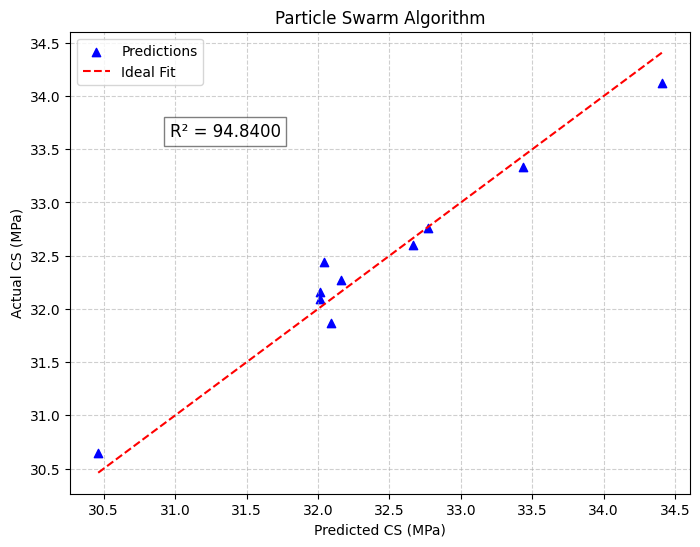

In [215]:
# Scatter plot for compressive strength
r2 = 94.84
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(yhat_cs, y_ori_cs, marker='^', color='blue', label="Predictions")  # Triangular points

# Plot ideal line
plt.plot([min(yhat_cs), max(yhat_cs)], [min(yhat_cs), max(yhat_cs)], color='red', linestyle='dashed', label="Ideal Fit")

# Labels and title
plt.xlabel("Predicted CS (MPa)")
plt.ylabel("Actual CS (MPa)")
plt.title("Particle Swarm Algorithm")

# Display R² value on the plot
plt.text(min(yhat_cs) + 0.5, max(y_ori_cs) - 0.5, f"R² = {r2:.4f}", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("pso_cs_plot.png", dpi=300, bbox_inches="tight")
plt.show()

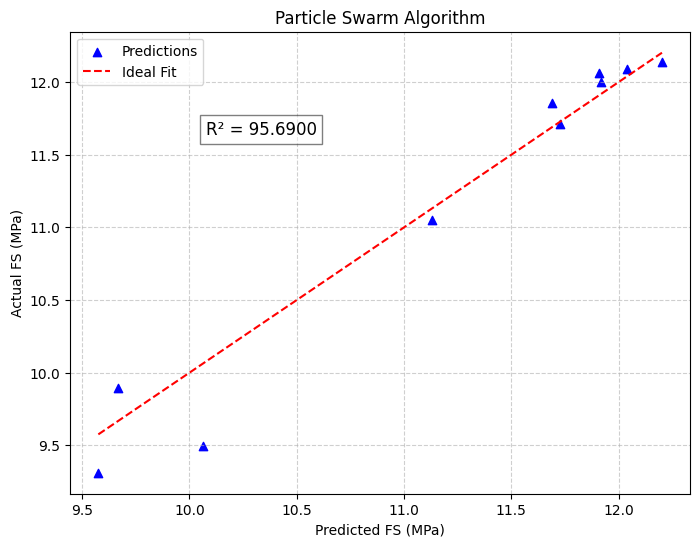

In [ ]:
# Scatter plot for flexural strength
r2 = 95.69
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(yhat_fs, y_ori_fs, marker='^', color='blue', label="Predictions")  # Triangular points

# Plot ideal line
plt.plot([min(yhat_fs), max(yhat_fs)], [min(yhat_fs), max(yhat_fs)], color='red', linestyle='dashed', label="Ideal Fit")

# Labels and title
plt.xlabel("Predicted FS (MPa)")
plt.ylabel("Actual FS (MPa)")
plt.title("Particle Swarm Algorithm")

# Display R² value on the plot
plt.text(min(yhat_fs) + 0.5, max(y_ori_fs) - 0.5, f"R² = {r2:.4f}", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("pso_fs_plot.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Annealing (SA) Algorithm
- According to the original paper the initial temperature, final temperature, alpha coefficient, and maximum number of iterations are set to 90, 0.1, 0.9, and 1000, respectively.

In [279]:
seed_all(42)

# Extract W/C, PN Fiber, and SP values from the random_samples dataframe
initial_solutions = random_samples[['W/C', 'PN_Fiber (%)', 'SP (kg/m³)']].values

# SA Parameters
initial_temperature = 100.0
final_temperature = 10.0
alpha = 0.8
max_iterations = 100

In [280]:
seed_all(42)

# Define fitness function
def fitness_function(params):
    w_c, pn, sp = params
    input_data = np.array([[w_c, pn, sp]])
    scaled_input = scaler.transform(input_data)
    cs, fs = ann_model.predict(scaled_input)[0]
    return -(cs + fs)  # Maximizing strength

# Simulated Annealing Implementation
def simulated_annealing():

    best_solutions = []
    for initial_solution in initial_solutions:

        current_solution = initial_solution.copy()
        best_solution = initial_solution.copy()
        current_fitness = fitness_function(current_solution)
        best_fitness = current_fitness
        temperature = initial_temperature
        
        for iteration in range(max_iterations):

            # Generate a new candidate solution by perturbing the current solution
            new_solution = current_solution + np.random.uniform(-0.01, 0.01, size=current_solution.shape)
            new_solution = np.clip(new_solution, [0.30, 0.0, 1.0], [0.50, 2.0, 5.0])
            new_fitness = fitness_function(new_solution)
            
            # Accept new solution based on SA acceptance criteria
            if new_fitness < current_fitness or np.exp((current_fitness - new_fitness) / temperature) > np.random.rand():
                current_solution = new_solution
                current_fitness = new_fitness
                
                if new_fitness < best_fitness:
                    best_solution = new_solution
                    best_fitness = new_fitness
            
            # Reduce temperature
            temperature *= alpha
            
            # Stop if temperature reaches final limit
            if temperature < final_temperature:
                break
        
        best_solutions.append(best_solution)
    
    return np.array(best_solutions)

In [281]:
seed_all(42)

# Run SA to get the 10 best optimized mix designs
optimized_solutions = simulated_annealing()

df_best_sa_designs = pd.DataFrame(optimized_solutions, columns=["w/c", "pn", "sp"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [282]:
seed_all(42)

# Convert to DataFrame
df_best_sa_designs = pd.DataFrame([each for each in optimized_solutions], columns=["w/c", "pn", "sp"])

df_best_sa_designs["cs_28d_pred"], df_best_sa_designs["fs_28d_pred"] = zip(*[
    ann_model.predict(scaler.transform(np.array([[w_c, pn, sp]])))[0] 
    for w_c, pn, sp in df_best_sa_designs[["w/c", "pn", "sp"]].values
])

# Update fitness based on ANN-predicted values
df_best_sa_designs["Fitness"] = df_best_sa_designs["cs_28d_pred"] + df_best_sa_designs["fs_28d_pred"]

# Select top 10 best mix designs based on highest (CS + FS)
df_best_sa_designs = df_best_sa_designs.nlargest(10, "Fitness")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

### SA algorithm prediction using ANN model

In [283]:
df_sa_ann = df_best_sa_designs[['w/c', 'pn', 'sp', 'cs_28d_pred', 'fs_28d_pred']]
df_sa_ann = df_sa_ann.reset_index(drop=True)
df_sa_ann

,w/c,pn,sp,cs_28d_pred,fs_28d_pred
0,0.457082,0.290649,3.550310,33.562580,13.622451
1,0.407311,0.020991,3.848648,34.487267,11.928912
2,0.430853,0.179211,3.731614,33.368237,12.408437
3,0.426519,0.391928,4.185167,32.703640,12.160129
4,0.427228,0.555243,4.550000,32.164440,12.201753
5,0.434432,0.566203,4.235534,31.772228,12.223085
6,0.441370,0.190453,2.185688,32.635429,11.108672
7,0.449002,0.957125,4.554395,29.982006,12.345550
8,0.409405,0.576603,3.471240,32.093777,9.667226
9,0.436696,0.982213,4.560902,30.230345,11.463272


### Treating multilinear regression prediction as the original/real-time mechanical testing data

In [284]:
cs_values = []
fs_values = []

for index, row in df_best_sa_designs.iterrows():
    w_c = row['w/c']
    pn = row['pn']
    sp = row['sp']
    
    cs, fs = predict_strength_regression(w_c, pn, sp)
    
    cs_values.append(cs)
    fs_values.append(fs)

df_best_sa_designs["cs_28d"] = cs_values
df_best_sa_designs["fs_28d"] = fs_values

df_sa = df_best_sa_designs.copy()
df_sa = df_sa.reset_index(drop=True)
df_sa

,w/c,pn,sp,cs_28d_pred,fs_28d_pred,Fitness,cs_28d,fs_28d
0,0.457082,0.290649,3.550310,33.562580,13.622451,47.185032,32.057503,13.439282
1,0.407311,0.020991,3.848648,34.487267,11.928912,46.416180,34.271205,11.958941
2,0.430853,0.179211,3.731614,33.368237,12.408437,45.776672,33.122139,12.589896
3,0.426519,0.391928,4.185167,32.703640,12.160129,44.863770,32.682332,12.201528
4,0.427228,0.555243,4.550000,32.164440,12.201753,44.366192,32.274414,12.138392
5,0.434432,0.566203,4.235534,31.772228,12.223085,43.995316,31.890113,12.134067
6,0.441370,0.190453,2.185688,32.635429,11.108672,43.744102,31.893730,11.369017
7,0.449002,0.957125,4.554395,29.982006,12.345550,42.327557,30.306522,12.045314
8,0.409405,0.576603,3.471240,32.093777,9.667226,41.761002,31.868831,9.895952
9,0.436696,0.982213,4.560902,30.230345,11.463272,41.693619,30.460906,11.314509


### Performance metrics of SA

In [ ]:
# Performance 
y_ori_cs = df_sa['cs_28d'].values
y_ori_fs = df_sa['fs_28d'].values
yhat_cs  = df_sa_ann['cs_28d_pred'].values
yhat_fs  = df_sa_ann['fs_28d_pred'].values

# Compute metrics separately for CS and FS
metrics = {}
for name, (y_t, y_p) in zip(["CS", "FS"], [(y_ori_cs, yhat_cs), (y_ori_fs, yhat_fs)]):
    metrics[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_t, y_p)),
        "R² Score": r2_score(y_t, y_p),
        "MAE": mean_absolute_error(y_t, y_p),
        "MAPE": mean_absolute_percentage_error(y_t, y_p) * 100  # Convert to percentage
    }

# Print Evaluation Metrics
print('SA performance metrics:')
for key, values in metrics.items():
    print(f"\nMetrics for {key}:")
    print(f"RMSE: {values['RMSE']:.4f}")
    print(f"R² Score: {values['R² Score']:.4f}")
    print(f"MAE: {values['MAE']:.4f}")
    print(f"MAPE: {values['MAPE']:.2f}%")


SA performance metrics:

Metrics for CS:
RMSE: 0.5620
R² Score: 0.7405
MAE: 0.3738
MAPE: 1.17%

Metrics for FS:
RMSE: 0.1770
R² Score: 0.9594
MAE: 0.1527
MAPE: 1.31%


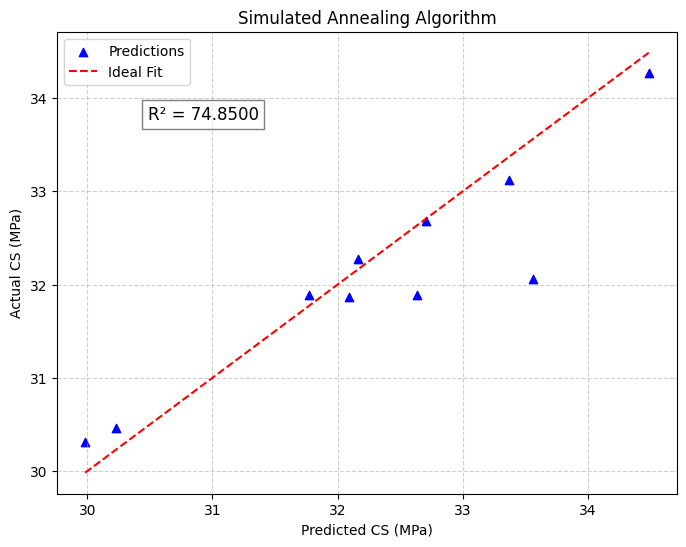

In [288]:
# Scatter plot for compressive strength
r2 = 74.85
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(yhat_cs, y_ori_cs, marker='^', color='blue', label="Predictions")  # Triangular points

# Plot ideal line
plt.plot([min(yhat_cs), max(yhat_cs)], [min(yhat_cs), max(yhat_cs)], color='red', linestyle='dashed', label="Ideal Fit")

# Labels and title
plt.xlabel("Predicted CS (MPa)")
plt.ylabel("Actual CS (MPa)")
plt.title("Simulated Annealing Algorithm")

# Display R² value on the plot
plt.text(min(yhat_cs) + 0.5, max(y_ori_cs) - 0.5, f"R² = {r2:.4f}", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("sa_cs_plot.png", dpi=300, bbox_inches="tight")
plt.show()

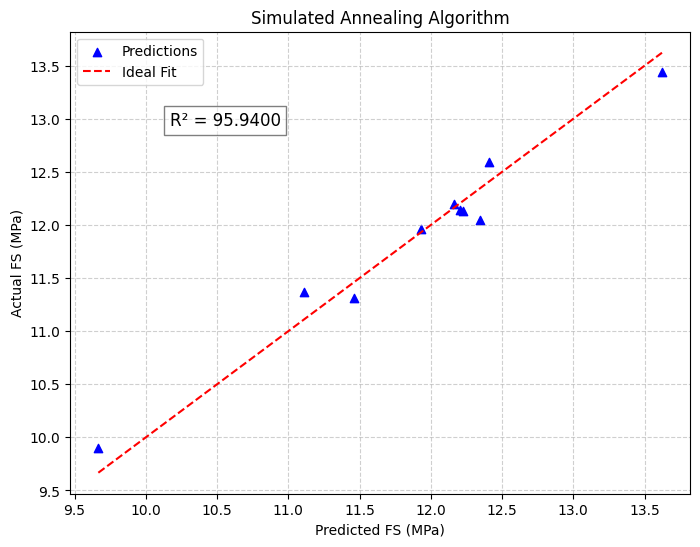

In [289]:
# Scatter plot for flexural strength
r2 = 95.94
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(yhat_fs, y_ori_fs, marker='^', color='blue', label="Predictions")  # Triangular points

# Plot ideal line
plt.plot([min(yhat_fs), max(yhat_fs)], [min(yhat_fs), max(yhat_fs)], color='red', linestyle='dashed', label="Ideal Fit")

# Labels and title
plt.xlabel("Predicted FS (MPa)")
plt.ylabel("Actual FS (MPa)")
plt.title("Simulated Annealing Algorithm")

# Display R² value on the plot
plt.text(min(yhat_fs) + 0.5, max(y_ori_fs) - 0.5, f"R² = {r2:.4f}", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("sa_fs_plot.png", dpi=300, bbox_inches="tight")
plt.show()